In [1]:
import collections
import networkx as nx
import numpy as np
import os
import random
from sklearn import linear_model
import json as json

In [2]:
# plot settings
import matplotlib.pyplot as plt

FIGSIZE_TWOCOL = (10,5)
FIGSIZE_ONECOL = (5,5)

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size= MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize= MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize= MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Statistiche generali

In [3]:
g = nx.read_edgelist('../network/networks/edge_list.txt',
                     create_using=nx.DiGraph(), nodetype=int, data=False)

In [4]:
# Erdos-Renyi random network
g_er = nx.read_edgelist('../network/networks/er_edge_list.txt',
                                create_using=nx.DiGraph(), nodetype=int,
                                data=False)

In [260]:
# Barabasi-Albert network
g_ba = nx.read_edgelist('../network/networks/ba_edge_list.txt',
                        create_using=nx.Graph(), nodetype=int,
                        data=False)


In [4]:
def network_summary(g, directed=True):
    """ returns dictionary with the network informations"""

    if(directed):
        """undirected graph statistics for directed graph, 
        NOTE: reciprocal links are lost"""
        g_und = g.to_undirected()
    else:
        g_und = g
        
    g_info= {}
    g_info['N'] = nx.number_of_nodes(g)
    g_info['L'] = nx.number_of_edges(g)

    degrees_und = [d for n,d in g_und.degree()]

    g_info['k_avg_und'] = int(np.mean(degrees_und))
    g_info['k_max_und'] = np.max(degrees_und)
    g_info['k_min_und'] = np.min(degrees_und)

    if(directed):
        
        in_degrees = [d for n, d in g.in_degree()]
        out_degrees = [d for n, d in g.out_degree()]
        degrees = [d for n,d in g.degree()]

        g_info['k_avg'] = int(np.mean(in_degrees))
        g_info['k_in_max'] = np.max(in_degrees)
        g_info['k_in_min'] = np.min(in_degrees)
        g_info['k_out_max'] = np.max(out_degrees)
        g_info['k_out_min'] = np.min(out_degrees)
        g_info['k_max'] = np.max(degrees)
        g_info['k_min'] = np.min(degrees)

        
    return g_info

In [5]:
g_info = network_summary(g, directed = True)

In [9]:
g_er_info = network_summary(g_er, directed = True)

In [279]:
g_ba_info = network_summary(g_ba , directed = False)

In [11]:
infos = {'g':g_info, 'g_er':g_er_info , 'g_ba':g_ba_info }

In [12]:
with open("network_infos.json", 'w') as f:
    f.write(json.dumps(infos, indent =4) )    

In [12]:
## choosing erdos-renyi probability
probER=float(g_info['_avg_und'])/(g_info['N'])
probER

0.0008671971275996896

- The network is sparse?

In [13]:
N = g_info['N']
L = g_info['L']
L_max = N*(N-1)/2
float(L)/L_max

0.001158157640820872

# Degree distribution

Questions:
- chi sono gli users che hanno il valore massimo di degree entrante/uscente?
- che caratteristiche in comune hanno?


In [14]:
in_degrees = [d for n, d in g.in_degree()]
out_degrees = [d for n, d in g.out_degree()]
degrees =[d for n,d in g.degree()]

# ordinamento
in_degrees.sort(reverse=True)
out_degrees.sort(reverse=True)
degrees.sort(reverse=True)

## Logarithmic binning

In [15]:
def log_binning(degrees, b=2, prob=True, split = False):
    """
    computing the degree distribution using log binning
    input:
    - degrees: list of the degrees
    - b=2: base step for the bins
    - prob=True, return the probabilities
    output:
    - degree_means
    - degree_probs
    if(prob=False) returns the counts 

    Example:
    degrees=list(range(16))
    means,probs= log_binning(degrees)
    print means
    print probs
    """
    degrees = [d for d in degrees if d>0]

    """ computing breaks """
    k=0
    breaks=[]
    while(b**(k-1)< max(degrees)):
        breaks.append(b**k)
        k+=1
    breaks.append(b**k)

    # splitting the degrees using the breaks
    splitted_degrees = {}
    for br in breaks:
        splitted_degrees[br]=[]

    for d in degrees:
        i=1
        #  print d
        while(d>=breaks[i]):
            i+=1
        splitted_degrees[breaks[i-1]].append(d)  

    # counting for each bin
    d_counts = {}
    for br in breaks:
        d_counts[br]=[]

    for br in breaks:
        d_counts[br] = len(splitted_degrees[br])

    counts = [d_counts[br] for br in breaks]

    # computing probabilities
    degree_probs = np.array(counts).astype(float)/(np.array(breaks)) 
    # normalization of the probabilities
    degree_probs= (degree_probs.astype(float))/sum(degree_probs)

    degree_means = [ np.mean(np.array(splitted_degrees[br])) for br in breaks ]
    if(split):
        return splitted_degrees
    
    if(prob):
        return degree_means, degree_probs
    else:
        return degree_means, counts

In [16]:
help(log_binning)

Help on function log_binning in module __main__:

log_binning(degrees, b=2, prob=True, split=False)
    computing the degree distribution using log binning
    input:
    - degrees: list of the degrees
    - b=2: base step for the bins
    - prob=True, return the probabilities
    output:
    - degree_means
    - degree_probs
    if(prob=False) returns the counts 
    
    Example:
    degrees=list(range(16))
    means,probs= log_binning(degrees)
    print means
    print probs



In [17]:
degrees=list(range(16))
means,probs= log_binning(degrees, split=False)
print means
print probs
splitted= log_binning(degrees, split=True)
print splitted

[1.0, 2.5, 5.5, 11.5, nan, nan]
[ 0.25  0.25  0.25  0.25  0.    0.  ]
{32: [], 1: [1], 2: [2, 3], 4: [4, 5, 6, 7], 8: [8, 9, 10, 11, 12, 13, 14, 15], 16: []}


/home/stefano/Py-envs/dm-py2/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stefano/Py-envs/dm-py2/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
import gc
gc.collect()

0

In [372]:
# total degree
degree_counts = collections.Counter(d for d in degrees)
degree_counts = [degree_counts.get(i, 0) for i in range(max(degree_counts) + 1) ] #if degree_counts.get(i,0)>0]
degree= np.arange(len(degree_counts))
degree_probs = np.array(degree_counts).astype(float)/len(degrees)

In [224]:
# out degree
out_degrees =[d for n,d in g.out_degree()]

out_degree_counts = collections.Counter(d for n, d in g.out_degree())
out_degree_counts = [out_degree_counts.get(i, 0) for i in range(max(out_degree_counts) + 1)]
degree_out= np.arange(len(out_degree_counts))
out_degree_probs = np.array(out_degree_counts).astype(float)/g_info['N']

In [225]:
# in degree
in_degree_counts = collections.Counter(d for n, d in g.in_degree())
in_degree_counts = [in_degree_counts.get(i, 0) for i in range(max(in_degree_counts) + 1)]
degree_in= np.arange(len(in_degree_counts))
in_degree_probs = np.array(in_degree_counts).astype(float)/g_info['N']


In [226]:
# Erdos-Renyi degree
er_degree_counts = collections.Counter(d for n, d in g_er.degree())
er_degree_counts = [er_degree_counts.get(i, 0) for i in range(max(er_degree_counts) + 1)]
er_degree= np.arange(len(er_degree_counts))
er_degree_probs = np.array(er_degree_counts).astype(float)/g_info['N']

In [227]:
# Barabasi-Albert degree
ba_degree_counts = collections.Counter(d for n, d in g_ba.degree())
ba_degree_counts = [ba_degree_counts.get(i, 0) for i in range(max(ba_degree_counts) + 1) ]
ba_degree= np.arange(len(ba_degree_counts))
ba_degree_probs = np.array(ba_degree_counts).astype(float)/g_ba.number_of_nodes()

In [244]:
# proability distributions with log binning
# tot degree
prob = True
degrees =[d for n,d in g.degree()]
degree_means, degree_log_probs = log_binning(degrees, prob =prob)
# in-degree
in_degrees =[d for n,d in g.in_degree()]
in_degree_means, in_degree_log_probs = log_binning(in_degrees, prob =prob)
# out-degree
out_degrees =[d for n,d in g.out_degree()]
out_degree_means, out_degree_log_probs = log_binning(out_degrees , prob =prob)
#ER-degree
er_degrees =[d for n,d in g_er.degree()]
er_degree_means, er_degree_log_probs = log_binning(er_degrees, prob =prob)
#BA-degree
ba_degrees =[d for n,d in g_ba.degree()]
ba_degree_means, ba_degree_log_probs = log_binning(ba_degrees, prob = prob)

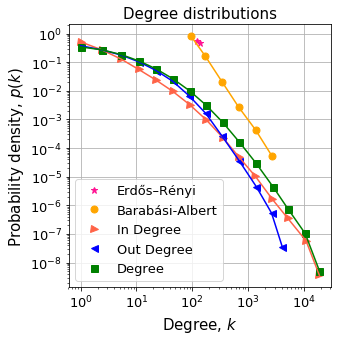

In [376]:
fig, ax = plt.subplots(figsize=FIGSIZE_ONECOL)
MARKERSIZE= 7

# random networks
plt.plot(er_degree_means, er_degree_log_probs, '*', color='deeppink',   label=u'Erdős–Rényi', markersize = MARKERSIZE)
plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label=u'Barabási-Albert', markersize = MARKERSIZE)
# real network
plt.plot(in_degree_means, in_degree_log_probs, '>', color='tomato',   label='In Degree', markersize = MARKERSIZE)
plt.plot(out_degree_means, out_degree_log_probs, '<', color='blue',   label='Out Degree', markersize = MARKERSIZE)
plt.plot(degree_means, degree_log_probs, 's', color='green',   label='Degree', markersize = MARKERSIZE)

plt.plot(er_degree_means, er_degree_log_probs, '-', color='deeppink')
plt.plot(ba_degree_means, ba_degree_log_probs, '-', color='orange')
# real network
plt.plot(in_degree_means, in_degree_log_probs, '-', color='tomato')
plt.plot(out_degree_means, out_degree_log_probs, '-', color='blue')
plt.plot(degree_means, degree_log_probs, '-', color='green')

plt.grid()
plt.title("Degree distributions")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                                     
plt.loglog()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/degree_distributions.pdf")                                     

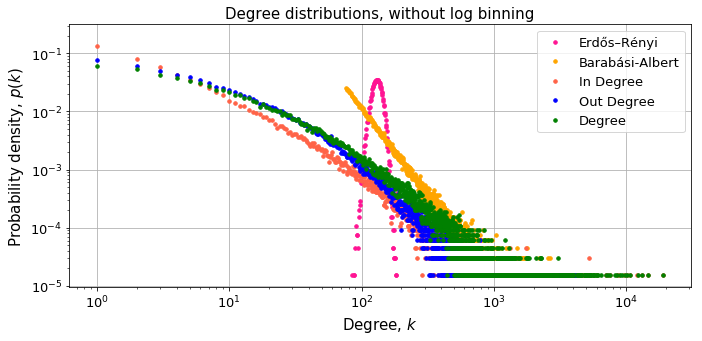

In [381]:
fig, ax = plt.subplots(figsize=FIGSIZE_TWOCOL)
MARKERSIZE= 7

# random networks
plt.plot(er_degree, er_degree_probs, '.', color='deeppink',   label=u'Erdős–Rényi', markersize = MARKERSIZE)
plt.plot(ba_degree, ba_degree_probs, '.', color='orange',   label=u'Barabási-Albert', markersize = MARKERSIZE)
# real network
plt.plot(degree_in, in_degree_probs, '.', color='tomato',   label='In Degree', markersize = MARKERSIZE)
plt.plot(degree_out, out_degree_probs, '.', color='blue',   label='Out Degree', markersize = MARKERSIZE)
plt.plot(degree, degree_probs, '.', color='green',   label='Degree', markersize = MARKERSIZE)

plt.grid()
plt.title("Degree distributions, without log binning")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                                     
plt.loglog()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/degree_distributions_nobinlog.pdf")                                     

In [379]:
# regression testing
begin = 30
end = 200
counts_Y = np.log(in_degree_probs[begin:end])
degree_X = np.log(degree_in[begin:end]).astype(float)
degree_X=degree_X.reshape(end-begin,1)
regr = linear_model.LinearRegression()
regr.fit(degree_X, counts_Y)
count_pred = regr.predict(degree_X)+0.5

In [380]:
print regr.coef_[0]
print regr.intercept_
print regr.score(degree_X, counts_Y)

-1.64533850716
0.285776511621
0.95378108165


In [375]:
def regression(degree, degree_probs, begin, end, h_adjust=-0, color= "black"):
    """regression analysis between begin and end, 
    plotting of the line and returns the slope"""
    counts_Y = np.log(degree_probs[begin:end])
    degree_X = np.log(degree[begin:end]).astype(float)
    degree_X=degree_X.reshape(end-begin,1)
    regr = linear_model.LinearRegression()
    regr.fit(degree_X, counts_Y)
    count_pred = regr.predict(degree_X)+h_adjust
    plt.plot( np.exp(degree_X), np.exp(count_pred), color= color)
    return -regr.coef_[0]

## In-degree distribution

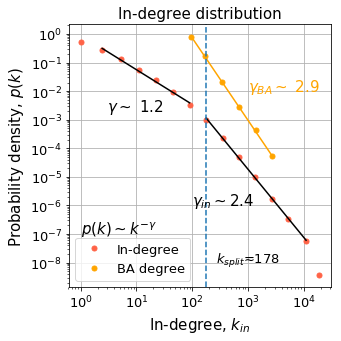

In [378]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(in_degree_means, in_degree_log_probs, 'o', color='tomato',   label='In-degree', markersize = 5)
##plt.plot(degree_out, out_degree_probs, '.', color='green',   label='Original')

# barabasi
plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label='BA degree', markersize = 5)
gamma_ba = regression(ba_degree_means, ba_degree_log_probs, 6, 12, color='orange').round(1)
plt.text(1000,float(1)/100, "$\gamma_{BA}\sim $"+" {}".format(gamma_ba), color = 'orange')


split = 7
gamma_in_1 = regression(in_degree_means, in_degree_log_probs, 1,split).round(1)
gamma_in_2 = regression(in_degree_means, in_degree_log_probs, split, 14).round(1)

plt.text(3, (float(1)/500), "$\gamma \sim $ {}".format(gamma_in_1))
plt.text(100,float(1)/1000000, "$\gamma_{in} \sim $"+"{}".format(gamma_in_2))
plt.text(1,float(1)/10**7, "$p(k) \sim k^{-\gamma}  $ ",fontsize =15)
# info on the splitting

in_degree_split = in_degree_means[split].round(0)
plt.axvline(in_degree_split, 0,1000, linestyle='--')
plt.text(1.5*in_degree_split, float(1)/10**8, "$k_{split} \eqsim$"+"{:.0f}".format(in_degree_split), fontsize=SMALL_SIZE)

plt.title("In-degree distribution")
plt.xlabel("In-degree, $k_{in}$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.legend(loc =3)
plt.tight_layout()
plt.savefig("imgs/in_degree_distribution.pdf")                                     

## Out-degree distribution

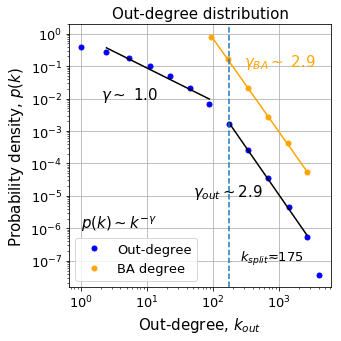

In [360]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(out_degree_means, out_degree_log_probs, 'o', color='blue',   label='Out-degree', markersize = 5)

# barabasi
plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label='BA degree', markersize = 5)
gamma_ba = regression(ba_degree_means, ba_degree_log_probs, 6, 12, color='orange').round(1)
plt.text(300,float(1)/10, "$\gamma_{BA}\sim $"+" {}".format(gamma_ba), color = 'orange')

split = 7
gamma_out_1 = regression(out_degree_means, out_degree_log_probs, 1,split).round(1)
gamma_out_2 = regression(out_degree_means, out_degree_log_probs, split, 12).round(1)

plt.text(2, (float(1)/100), "$\gamma \sim $ {}".format(gamma_out_1))
plt.text(50,float(1)/100000, "$\gamma_{out} \sim $"+ "{}".format(gamma_out_2))
plt.text(1,float(1)/10**6, "$p(k) \sim k^{-\gamma}  $ ",fontsize =15)
# info on the splitting

out_degree_split = out_degree_means[split].round(0)
plt.axvline(out_degree_split, 0,1000, linestyle='--')
plt.text(1.5*out_degree_split, float(1)/10**7, "$k_{split} \eqsim$"+"{:.0f}".format(out_degree_split), fontsize=SMALL_SIZE)

plt.title("Out-degree distribution")
plt.xlabel("Out-degree, $k_{out}$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/out_degree_distribution.pdf")                                     

Tot degree 

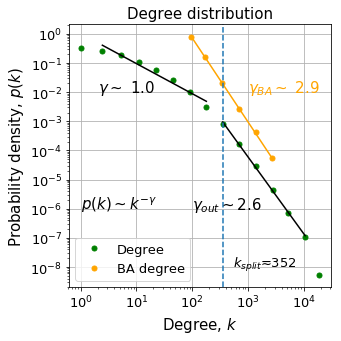

In [365]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(degree_means, degree_log_probs, 'o', color='green',   label='Degree', markersize = 5)

# barabasi
plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label='BA degree', markersize = 5)
gamma_ba = regression(ba_degree_means, ba_degree_log_probs, 6, 12, color='orange').round(1)
plt.text(1000,float(1)/100, "$\gamma_{BA}\sim $"+" {}".format(gamma_ba), color = 'orange')

split = 8
gamma_1 = regression(degree_means, degree_log_probs, 1,split).round(1)
gamma_2 = regression(degree_means, degree_log_probs, split, 14).round(1)

plt.text(2, (float(1)/100), "$\gamma \sim $ {}".format(gamma_1))
plt.text(100,float(1)/1000000, "$\gamma_{out} \sim $"+ "{}".format(gamma_2))
plt.text(1,float(1)/10**6, "$p(k) \sim k^{-\gamma}  $ ",fontsize =15)
# info on the splitting

degree_split = degree_means[split].round(0)
plt.axvline(degree_split, 0,1000, linestyle='--')
plt.text(1.5*degree_split, float(1)/10**8, "$k_{split} \eqsim$"+"{:.0f}".format(degree_split), fontsize=SMALL_SIZE)

plt.title("Degree distribution")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/tot_degree_distribution.pdf")                                     

# Connected components

In [9]:
print nx.is_strongly_connected(g)
print nx.is_weakly_connected(g)
print nx.is_strongly_connected(g_er)
print nx.is_weakly_connected(g_er)
print nx.is_connected(g_ba)

False
False


True
True
True

In [68]:
print nx.number_strongly_connected_components(g)
print nx.number_weakly_connected_components(g)

15757


62


In [ ]:
        print 'The Erdős–Rényi network is strongly connected with ' + \
            str(nx.number_strongly_connected_components(er_g)) + ' strongly ' \
            'connected components'
    elif nx.is_weakly_connected(er_g):
        print 'The Erdős–Rényi is weakly connected with ' + \
            str(nx.number_weakly_connected_components(er_g)) + \
            ' weakly connected components'
    else:
        print 'The Erdős–Rényi is neither strongly connected nor weakly ' + \
            'connected'

    if nx.is_connected(ba_g):
        print 'The Barabási–Albert network is connected with ' + \
            str(nx.number_connected_components(ba_g)) + \
            ' connected components'
    else:
        print 'The Barabási–Albert is not connected'


In [10]:
g_weak = collections.Counter(len(c)
                                 for c in nx.weakly_connected_components(g))
g_strong = collections.Counter(
        len(c)for c in nx.strongly_connected_components(g)
    )
er_weak = collections.Counter(len(c) for c in nx.
                                  weakly_connected_components(g_er))
er_strong = collections.Counter(len(c) for c in nx.
                                    strongly_connected_components(g_er))

In [11]:
er_weak

Counter({65729: 1})

In [29]:
x_weak = list(np.union1d(g_weak.keys(), er_weak.keys()))
x_strong = list(np.union1d(g_strong.keys(), er_strong.keys()))
y_weak = [g_weak[k] if k in g_weak else 0 for k in x_weak]
y_strong = [g_strong[k] if k in g_strong else 0 for k in x_strong]
y_weak_er = [er_weak[k] if k in er_weak else 0 for k in x_weak]

import copy
y_weak_lab = copy.copy(y_weak)
y_weak_lab[-1] =1

y_strong_lab = copy.copy(y_strong)
y_strong_lab[-1] =1


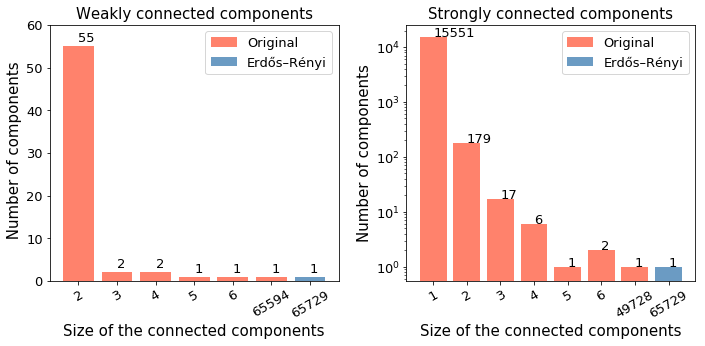

In [71]:
#plt.subplots(figsize = (10,10))
plt.subplots(figsize = FIGSIZE_TWOCOL)

plt.subplot(121)
plt.bar(range(len(x_weak)),y_weak,
            color='tomato', label='Original', alpha=.8)

for i in range(len(x_weak)):
    plt.text( i, y_weak_lab[i]+1, y_weak_lab[i] )

plt.bar(range(len(x_weak)), y_weak_er,
         color='steelblue', label=u'Erdős–Rényi', alpha=.8)
plt.xticks(range(len(x_weak)), x_weak, rotation = 30)
plt.title('Weakly connected components')
plt.xlabel('Size of the connected components')
plt.ylabel(' Number of components')
plt.legend()
plt.ylim(0,60)

plt.subplot(122)
plt.bar(range(len(x_strong)),
        [g_strong[k] if k in g_strong else 0 for k in x_strong],
        color='tomato', label='Original', log=True, alpha=.8)
plt.bar(range(len(x_strong)),
        [er_strong[k] if k in er_strong else 0 for k in x_strong],
        color='steelblue', label=u'Erdős–Rényi', log=True, alpha=.8)
for i in range(len(x_strong)):
    plt.text( i, y_strong_lab[i], y_strong_lab[i] )

plt.xticks(range(len(x_strong)), x_strong, rotation =30)
plt.title('Strongly connected components')
plt.xlabel('Size of the connected components')
plt.ylabel('Number of components')
plt.legend()

plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=1.4, wspace=0.2,
                    hspace=0.2)

plt.tight_layout()
plt.savefig('./imgs/connectivity.pdf', format='pdf')


# Path analysis
The computation complexity for the average shortest path of a network is of the order of..


In [6]:
import datetime 
import time

In [7]:
g_und = g.to_undirected()

In [9]:
g_c = [g_und.subgraph(c) for c in nx.connected_components(g_und)]

In [12]:
largest_cc = g_c[0]
print len(largest_cc)
n_max = len(distances)**len(distances)/2

65594


In [77]:
import random
def sample_distances(g, n = 1000):
    """
    computes the shortest path lengths of a sample of n nodes of a graph g
    returns: list of distances computed
    """
    temp = g.nodes()
    nodes = [nd for nd in temp]
    distances = []
    for i in range(n):
        i1 = random.randint(0,len(nodes)-1)
        i2 = random.randint(0,len(nodes)-1)
        try:
            distances.append( nx.shortest_path_length(g, nodes[i1], nodes[i2]))
        except nx.NetworkXNoPath:
            continue
    print np.mean(distances)
    return distances

## estimating computation time

In [45]:
n_pairs = [1000, 10000, 20000, 50000, 80000, 100000]

In [46]:
times= []
for L in n_pairs:
    start = datetime.datetime.now()
    distances = sample_distances(largest_cc,L)
    end = datetime.datetime.now()
    times.append( (end-start).seconds )

In [47]:
print times

[1, 11, 20, 51, 78, 100]


In [67]:
# time regression 
Y = np.array(times)
X = np.array(n_pairs)
X=X.reshape(len(X),1)
regr = linear_model.LinearRegression()
regr.fit(X, Y)
X_pred = np.linspace(1000, n_max, num = 100000)
X_pred = X_pred.reshape(len(X_pred), 1)
times_pred = regr.predict(X_pred)
#regr.coef_[0]

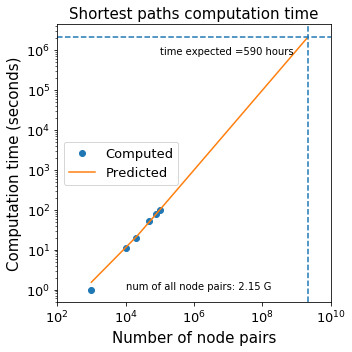

In [133]:
# computation time plot
plt.subplots(figsize=FIGSIZE_ONECOL)
plt.plot(n_pairs, times, 'o', label="Computed")
plt.plot(X_pred, times_pred, label="Predicted")
plt.axvline(n_max,0,100,linestyle='--')
plt.axhline(max(times_pred),0,100,linestyle='--')
plt.text(10**5, 8*10**5, "time expected ="+ "{:.0f} hours".format(max(times_pred)/3600))
plt.text(10**4, 1, "num of all node pairs: {:.2f} G".format( float(n_max)/(10**9)))
plt.xlim(10**2,10**10)
plt.loglog()
plt.legend()

plt.title("Shortest paths computation time")
plt.xlabel("Number of node pairs")
plt.ylabel("Computation time (seconds)")
plt.tight_layout()
#plt.yscale('log')
plt.savefig('./imgs/paths_computation_time.pdf', format='pdf')

In [183]:
# computing statistics
d_mean = np.mean(distances)
print d_mean
s=np.std(distances)
d_std= np.std(distances)/np.sqrt(len(distances))
print s
print d_std
print max(distances)

2.92407
0.674125088615
0.00213177070789
7


## average path length distribution

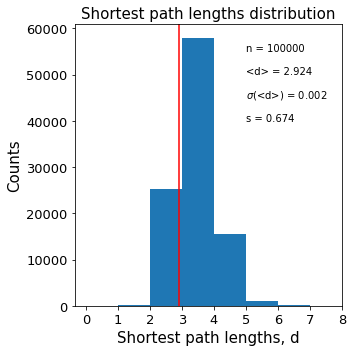

In [214]:
# average path length distribution
plt.subplots(figsize = FIGSIZE_ONECOL)
prova=plt.hist(distances,bins = np.arange(0,8))
plt.title("Shortest path lengths distribution")
plt.xlabel("Shortest path lengths, d")
plt.ylabel("Counts")
plt.tight_layout()
plt.xticks(np.arange(max(distances)+2))
plt.axvline(np.mean(distances), color="red")
plt.text(5,55000, "n = {:.0f}".format(len(distances)))
plt.text(5,50000, "<d> = {:.3f}".format(d_mean))
plt.text(5,45000, "$\sigma$"+"(<d>) = {:.3f}".format(d_std))
plt.text(5,40000, "s = {:.3f}".format(s))
plt.savefig('./imgs/paths_hist.pdf', format='pdf')


In [125]:
distances_g = sample_distances(g,1000)

3.65223097113


In [234]:
from scipy.stats import norm

In [254]:
p_max = 1-norm.cdf(np.max(distances), loc=d_mean, scale= s)
print p_max
#norm.ppf(0.5, loc=d_mean, scale = d_std)

4.9619119924e-10


In [259]:
norm.ppf(1-1.0/n_max, loc=d_mean, scale = s)

7.0069480861804552

In [233]:
print np.max(distances)
delta = np.max(distances)-d_mean
print delta/s


7
6.11063057269


In [283]:
print g_info

{'k_avg_und': 57, 'k_max_und': 19065, 'k_in_min': 0, 'k_in_max': 19064, 'k_min_und': 1, 'L': 2501757, 'k_out_min': 0, 'N': 65729, 'k_out_max': 4130, 'k_max': 19073, 'k_avg': 38, 'k_min': 1}


In [284]:
print g_ba_info

{'k_avg_und': 151, 'k_min_und': 76, 'k_max_und': 3640, 'L': 4989628, 'N': 65729}


In [ ]:
## Preserving degree random graph

In [136]:
temp = largest_cc.degree()
seq_degrees = [d for n,d in temp]
# random_g = nx.expected_degree_graph(seq_degrees, selfloops=False)
# nx.write_edgelist(random_g, '../network/networks/random_fixed_degree_edge_list.txt')

In [138]:
g_random = nx.read_edgelist('../network/networks/random_fixed_degree_edge_list.txt',
                     create_using=nx.Graph(), nodetype=int, data=False)

In [321]:
info_random_g = network_summary(g_random, directed =False)
info_g_cc = network_summary(largest_cc, directed =False)

In [158]:
distances_r = sample_distances(g_random, 100000)

2.86561984298


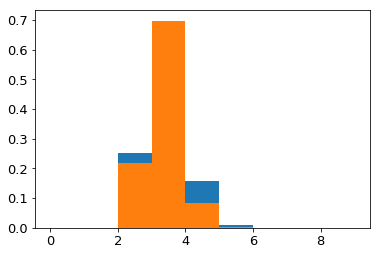

In [184]:
X = np.arange(10)
d_mean_random = np.mean(distances_r)
out = plt.hist(distances, bins= X,density =True)
out_r = plt.hist(distances_r, bins= X, density =True)

[0 1 2 3 4 5 6 7 8]


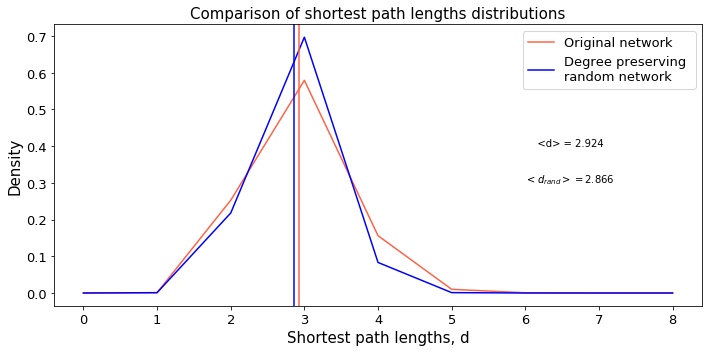

In [212]:
X=(out[1][:-1])
print (X)
plt.subplots(figsize = FIGSIZE_TWOCOL)
plt.plot(X, out[0], label = "Original network", color = "tomato")
plt.plot(X, out_r[0], label = "Degree preserving \nrandom network", color = "blue")
plt.axvline(d_mean, color= "tomato")
plt.axvline(d_mean_random, color= "blue")
plt.title("Comparison of shortest path lengths distributions")
plt.xlabel("Shortest path lengths, d")
plt.ylabel("Density")
plt.text(6,0.4, "    <d> = {:.3f}".format(d_mean))
plt.text(6,0.3, "$<d_{rand}> = $"+ "{:.3f}".format(d_mean_random))

plt.tight_layout()
plt.legend()
plt.savefig('./imgs/paths_hist_comparison.pdf', format='pdf')

In [322]:
info_random_g

{'L': 1856561, 'N': 63216, 'k_avg_und': 58, 'k_max_und': 13133, 'k_min_und': 1}

In [324]:
info_g_cc

{'L': 1895791, 'N': 65594, 'k_avg_und': 57, 'k_max_und': 19065, 'k_min_und': 1}

In [26]:
start = datetime.datetime.now()
distances_r = sample_distances(g_random)
end = datetime.datetime.now()


In [166]:
print np.mean(np.array(distances_r))
print np.max(distances_r)
print np.min(distances_r)
print np.std(distances_r)
print np.std(distances_r)/np.sqrt(len(distances_r))

2.86561984298
6
1
0.53947042213
0.00170608322526


(array([  0.00000000e+00,   8.38670326e-04,   2.21043001e-01,
          6.94617261e-01,   8.24031717e-02,   1.08264715e-03,
          1.52485514e-05,   0.00000000e+00,   0.00000000e+00]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

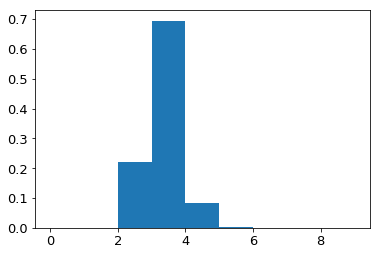

In [28]:
plt.hist(distances_r,bins = np.arange(0,10), density = True, cumulative =False)

In [154]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype=u'bar', align=u'mid', orientation=u'vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, hold=None, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequency 